In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb


In [ ]:
df = pd.read_csv("../Data/Hotels_Best_Discount.csv")
X = df[["Snapshot Date", "Checkin Date" , "DayDiff" , "WeekDay" , "Hotel_Encoded_Name"]]
y = df["Discount Code"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_xgb = y_train - 1
y_test_xgb = y_test - 1

In [69]:
models = {
    "XGBoost": xgb.XGBClassifier(
        colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=27,
        n_estimators=100, subsample=1.0, objective="multi:softmax", num_class=4, eval_metric="mlogloss"
    ),
    "Random Forest": RandomForestClassifier(
        bootstrap=False, max_depth=35, min_samples_split=6, n_estimators=100, random_state=42
    ),
    "Naïve Bayes": GaussianNB(var_smoothing=0.0001),
    "KNN": KNeighborsClassifier(metric="manhattan", n_neighbors=1, weights="distance"),
    "Decision Tree": DecisionTreeClassifier(
        criterion="entropy", max_depth=30, max_features=None, min_samples_leaf=1, min_samples_split=2, random_state=42
    )
}

In [70]:
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    if name == "XGBoost":
        model.fit(X_train, y_train_xgb)  
        y_pred = model.predict(X_test) + 1 
        y_pred_proba = model.predict_proba(X_test)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    fp = conf_matrix.sum(axis=0) - np.diag(conf_matrix)
    fn = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
    with np.errstate(divide='ignore', invalid='ignore'):
        precision = np.nan_to_num(np.diag(conf_matrix) / (np.diag(conf_matrix) + fp), nan=0.0)
        recall = np.nan_to_num(np.diag(conf_matrix) / (np.diag(conf_matrix) + fn), nan=0.0)
    roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class="ovr") if y_pred_proba is not None else None

    # Store results
    results[name] = {
        "Accuracy": accuracy,
        "ROC AUC": roc_auc,
        "FP": fp,
        "FN": fn,
        "Precision": precision,
        "Recall": recall,
        "Confusion Matrix": conf_matrix,
    }

    
    print(f"\n{name} Test Accuracy: {accuracy:.4f}")
    if roc_auc is not None:
        print(f"{name} ROC AUC Score: {roc_auc:.4f}")
    



Training XGBoost...

XGBoost Test Accuracy: 0.8059
XGBoost ROC AUC Score: 0.9455

Training Random Forest...

Random Forest Test Accuracy: 0.7770
Random Forest ROC AUC Score: 0.9288

Training Naïve Bayes...

Naïve Bayes Test Accuracy: 0.3471
Naïve Bayes ROC AUC Score: 0.5653

Training KNN...

KNN Test Accuracy: 0.7146
KNN ROC AUC Score: 0.8066

Training Decision Tree...

Decision Tree Test Accuracy: 0.7981
Decision Tree ROC AUC Score: 0.8640


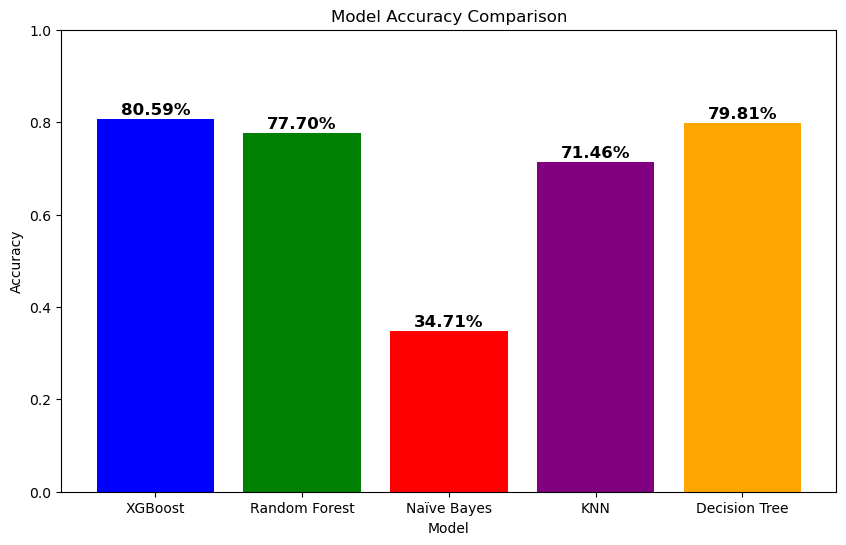

In [71]:
plt.figure(figsize=(10, 6))
model_names = list(models.keys())
accuracies = [results[m]["Accuracy"] for m in model_names]

bars = plt.bar(model_names, accuracies, color=["blue", "green", "red", "purple", "orange"])

plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.ylim(0, 1)

# Add percentage labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.2%}", ha='center', fontsize=12, fontweight='bold')

plt.show()


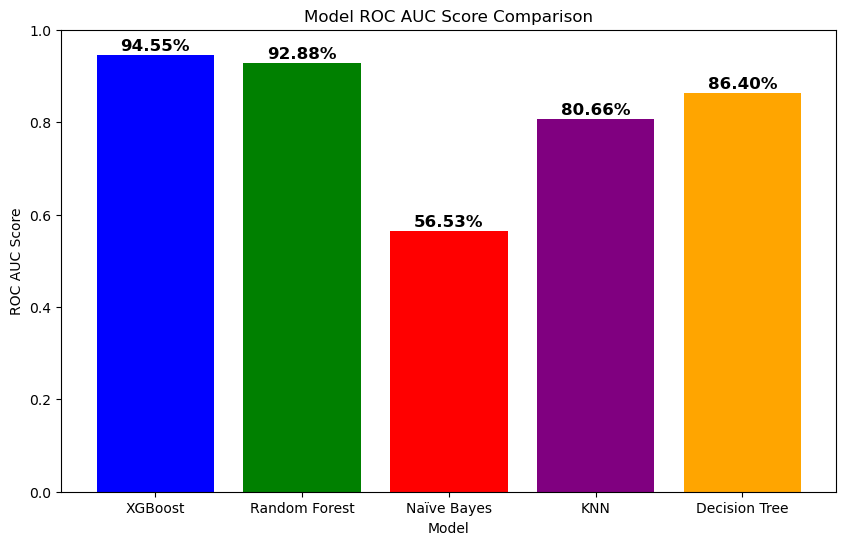

In [72]:
plt.figure(figsize=(10, 6))
model_names = list(models.keys())
roc_aucs = [results[m]["ROC AUC"] for m in model_names]

bars = plt.bar(model_names, roc_aucs, color=["blue", "green", "red", "purple", "orange"])

plt.xlabel("Model")
plt.ylabel("ROC AUC Score")
plt.title("Model ROC AUC Score Comparison")
plt.ylim(0, 1)

# Add percentage labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.2%}", ha='center', fontsize=12, fontweight='bold')

plt.show()


<Figure size 1200x600 with 0 Axes>

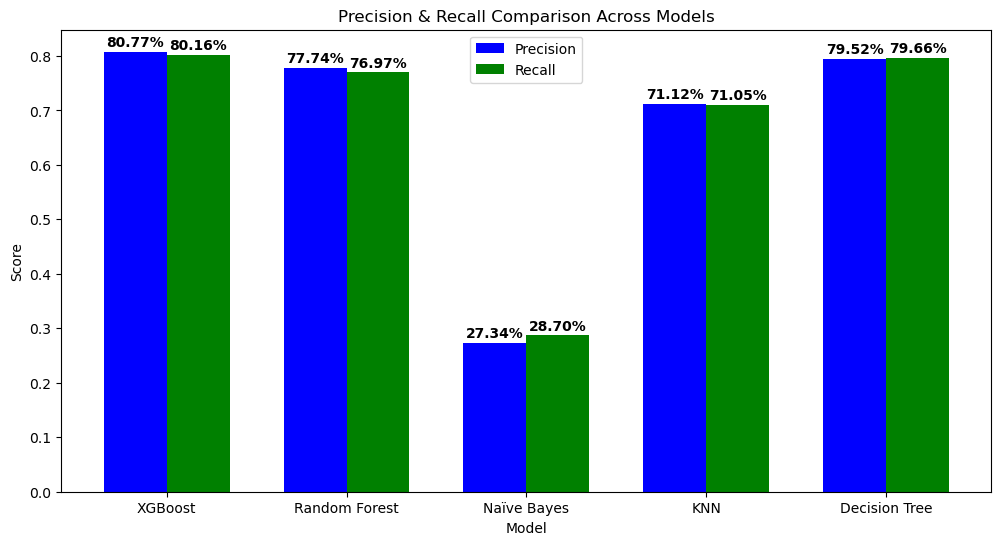

In [73]:
import numpy as np

plt.figure(figsize=(12, 6))

model_names = list(models.keys())
precision_scores = [np.mean(results[m]["Precision"]) for m in model_names]
recall_scores = [np.mean(results[m]["Recall"]) for m in model_names]

x = np.arange(len(model_names))  # Label locations
width = 0.35  # Width of bars

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, precision_scores, width, label="Precision", color="blue")
bars2 = ax.bar(x + width/2, recall_scores, width, label="Recall", color="green")

ax.set_xlabel("Model")
ax.set_ylabel("Score")
ax.set_title("Precision & Recall Comparison Across Models")
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()

# Add percentage labels on top of bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.2%}", ha='center', fontsize=10, fontweight='bold')

plt.show()


In [74]:
for model_name in models.keys():
    precision = results[model_name]["Precision"]
    recall = results[model_name]["Recall"]
    
    # Compute F1-score per class, handling division by zero
    f1_score = np.where(
        (precision + recall) == 0,  # Avoid division by zero
        0,  # Assign F1-score as 0 when precision and recall are both zero
        2 * (precision * recall) / (precision + recall)
    )

    # Store the average F1-score in results
    results[model_name]["F1 Score"] = np.mean(f1_score)


C:\Users\alon1\AppData\Local\Temp\ipykernel_21444\646235307.py:9: RuntimeWarning: invalid value encountered in divide
  2 * (precision * recall) / (precision + recall)


<Figure size 1200x600 with 0 Axes>

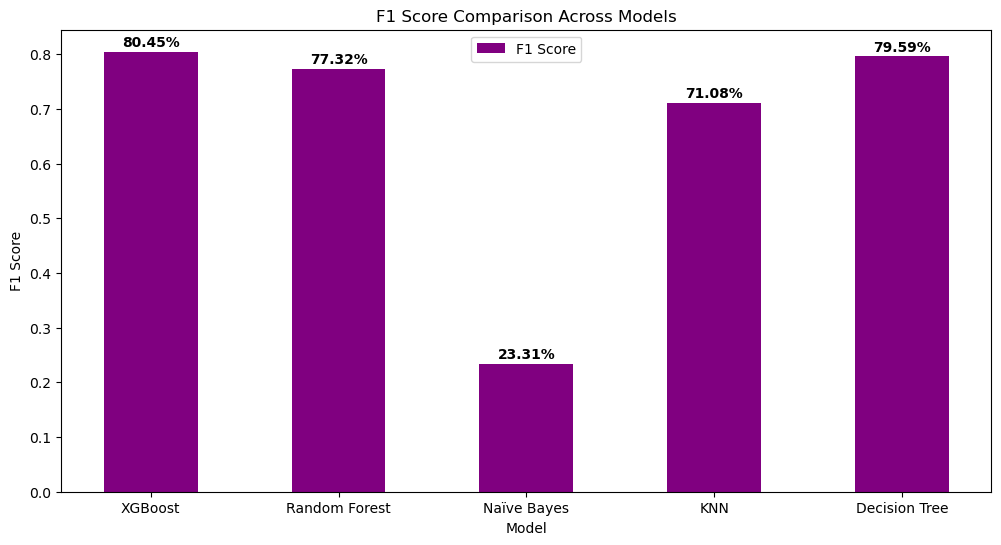

In [75]:
plt.figure(figsize=(12, 6))

model_names = list(models.keys())
f1_scores = [np.mean(results[m]["F1 Score"]) for m in model_names]

x = np.arange(len(model_names))  # Label locations
width = 0.5  # Width of bars

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(x, f1_scores, width, color="purple", label="F1 Score")

ax.set_xlabel("Model")
ax.set_ylabel("F1 Score")
ax.set_title("F1 Score Comparison Across Models")
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()

# Add percentage labels on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.2%}", ha='center', fontsize=10, fontweight='bold')

plt.show()

### **In Conclusion**
___
XGBoost is the best-performing algorithm based on all evaluation metrics.

The metrics is the most important for selecting the best model, based on:
1. **ROC AUC Score** – Best for evaluating overall model performance, as it measures how well the model distinguishes between classes.  
2. **F1 Score** – Ensures a balance between precision and recall, making it useful when class distribution is uneven.